# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                                                                     
Sample_092  A6NNI4;G8JLH6;P21926                                                                                                                  16.091
Sample_006  P51888                                                                                                                                17.242
Sample_188  P16152                                                                                                                                16.111
Sample_192  O43157                                                                                                                                15.156
Sample_029  A0A0A0MS52;A0A0A0MT11;H0Y6G2;Q13555;Q13555-10;Q13555-2;Q13555-3;Q13555-4;Q13555-5;Q13555-6;Q13555-7;Q13555-8;Q13555-9;Q5SWX3;Q8WU40   16.085
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups        
Sample_025  Q09328                   13.683
Sample_147  H0YEX9;P57087;P57087-3   15.844
Sample_107  F5H3H7;Q9Y644            13.449
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.584
            A0A075B6Q5                 12.407
            A0A075B6R2                 14.847
            A0A075B6S5                 13.593
            A0A087WSY4                 12.576
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.302
            Q9UI40;Q9UI40-2            12.703
            Q9UIW2                     12.997
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.912
            Q9UP79                     13.572
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.093,15.050,16.842,19.863,16.040,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.835,19.067,...,15.528,15.576,14.127,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.994,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.290,17.705,17.039,15.693,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.756,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.312,15.345,17.084,18.708,14.249,19.433,11.231,11.146
Sample_207,15.739,16.877,15.469,16.898,15.426,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.379,13.086,13.946,12.301,12.528,12.673,13.810,12.763,13.000,12.338
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.165,19.067,16.127,...,11.991,12.913,14.294,14.303,12.616,13.124,12.410,13.359,11.672,12.614
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,10.844,13.189,11.206,13.089,11.973,12.942,12.020,13.419,13.570,13.630
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.769,12.975,12.364,12.323,13.083,12.159,12.487,13.444,13.086,13.039
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.917,11.957,13.374,12.616,13.528,12.950,13.939,12.371,13.507,11.838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.076,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 328.99it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

100%|██████████| 2/2 [00:00<00:00,  7.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.52it/s]

100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.46it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.53it/s]

100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.72it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.26it/s]

100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.47it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.63it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.24it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.36it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.49it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.23it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.32it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.47it/s]

100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.15it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.67it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.36it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.09it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.89it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.21it/s]

100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.04it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.09it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.88it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.39it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.95it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.06it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.18it/s]

100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.45it/s]

 30%|███       | 3/10 [00:00<00:01,  6.23it/s]

 40%|████      | 4/10 [00:00<00:01,  3.94it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.47it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.16it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.14it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.15it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.29it/s]

100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.39it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.29it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.38it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.66it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.00it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.47it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.18it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.09it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.09it/s]

100%|██████████| 11/11 [00:02<00:00,  3.20it/s]

100%|██████████| 11/11 [00:02<00:00,  3.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.30it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.78it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.24it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.15it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.13it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.00it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.47it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.24it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.13it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.96it/s]

100%|██████████| 12/12 [00:03<00:00,  3.18it/s]

100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.35it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.46it/s]

 31%|███       | 4/13 [00:00<00:01,  4.56it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.28it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.18it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.36it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.46it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.57it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.97it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.43it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.22it/s]

100%|██████████| 13/13 [00:03<00:00,  3.04it/s]

100%|██████████| 13/13 [00:03<00:00,  3.88it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.57it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.80it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.34it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.21it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.01it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.05it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.04it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.05it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.78it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.44it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.42it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.35it/s]

100%|██████████| 14/14 [00:03<00:00,  3.26it/s]

100%|██████████| 14/14 [00:03<00:00,  3.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.17it/s]

 20%|██        | 3/15 [00:00<00:01,  6.32it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.28it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.82it/s]

 40%|████      | 6/15 [00:01<00:01,  4.62it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.64it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.00it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.09it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.86it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.07it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.32it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.71it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.54it/s]

100%|██████████| 15/15 [00:03<00:00,  3.04it/s]

100%|██████████| 15/15 [00:03<00:00,  3.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.058 0.021          0.669 0.414       0.086   
2             0.004 0.003      0.045 0.017          0.696 0.131       0.528   
3             0.004 0.002      0.042 0.012          0.700 0.121       0.619   
4             0.004 0.003      0.042 0.013          0.709 0.110       0.624   
5             0.005 0.005      0.043 0.014          0.687 0.092       0.666   
6             0.004 0.003      0.050 0.023          0.802 0.081       0.805   
7             0.005 0.004      0.047 0.016          0.795 0.082       0.801   
8             0.005 0.004      0.047 0.017          0.793 0.089       0.787   
9             0.004 0.002      0.043 0.015          0.790 0.091       0.791   
10            0.005 0.004      0.042 0.017          0.792 0.089       0.788   
11            0.005 0.004      0.043 0.012          0.794 0.086       0.798   
12            0.004 0.003      0.042 0.018          0.813 0.088       0.804   
13            0.004 0.002      0.048 0.023          0.803 0.090       0.800   
14            0.004 0.003      0.045 0.016          0.798 0.093       0.795   
15            0.004 0.000      0.042 0.014          0.794 0.089       0.794   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.076   0.147 0.116                  0.536 0.035        0.844   
2          0.109   0.592 0.090                  0.675 0.065        0.721   
3          0.128   0.646 0.090                  0.705 0.071        0.780   
4          0.103   0.657 0.079                  0.714 0.063        0.802   
5          0.112   0.671 0.079                  0.720 0.065        0.798   
6          0.111   0.798 0.071                  0.828 0.058        0.891   
7          0.109   0.793 0.070                  0.824 0.058        0.888   
8          0.099   0.785 0.067                  0.816 0.056        0.887   
9          0.107   0.785 0.072                  0.816 0.060        0.887   
10         0.108   0.785 0.074                  0.816 0.062        0.889   
11         0.115   0.790 0.073                  0.821 0.061        0.896   
12         0.107   0.803 0.070                  0.832 0.058        0.905   
13         0.109   0.795 0.072                  0.826 0.059        0.904   
14         0.101   0.791 0.070                  0.821 0.058        0.903   
15         0.103   0.788 0.069                  0.819 0.058        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.820 0.089        210.000 0.000  
2          0.080                  0.686 0.098        210.000 0.000  
3          0.078                  0.714 0.097        210.000 0.000  
4          0.072                  0.762 0.094        210.000 0.000  
5          0.066                  0.755 0.092        210.000 0.000  
6          0.050                  0.860 0.063        210.000 0.000  
7          0.051                  0.858 0.064        210.000 0.000  
8          0.052                  0.855 0.067        210.000 0.000  
9          0.054                  0.858 0.065        210.000 0.000  
10         0.054                  0.864 0.064        210.000 0.000  
11         0.053                  0.879 0.057        210.000 0.000  
12         0.052                  0.893 0.052        210.000 0.000  
13         0.052                  0.892 0.053        210.000 0.000  
14         0.052                  0.891 0.052        210.000 0.000  
15         0.051                  0.891 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 79.91it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.39it/s]

100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.76it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.11it/s]

100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.58it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.74it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.07it/s]

100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.68it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.51it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.09it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  3.22it/s]

100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.65it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.52it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.69it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.70it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.17it/s]

100%|██████████| 7/7 [00:01<00:00,  2.88it/s]

100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.00it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.10it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.12it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.29it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.87it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.89it/s]

100%|██████████| 8/8 [00:02<00:00,  2.82it/s]

100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.61it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.47it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.73it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.39it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.20it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.16it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.27it/s]

100%|██████████| 9/9 [00:03<00:00,  2.35it/s]

100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.37it/s]

 30%|███       | 3/10 [00:00<00:01,  4.00it/s]

 40%|████      | 4/10 [00:01<00:01,  3.26it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.95it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.70it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.63it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.55it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.76it/s]

100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.26it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.63it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.65it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.63it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.73it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.47it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.30it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.31it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.32it/s]

100%|██████████| 11/11 [00:03<00:00,  2.34it/s]

100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.10it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.72it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.09it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.83it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.73it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.52it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.96it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.02it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.91it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.74it/s]

100%|██████████| 12/12 [00:03<00:00,  2.75it/s]

100%|██████████| 12/12 [00:03<00:00,  3.23it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.81it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.98it/s]

 31%|███       | 4/13 [00:00<00:01,  4.61it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.44it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.17it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.64it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.23it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.66it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.48it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.37it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.34it/s]

100%|██████████| 13/13 [00:04<00:00,  2.27it/s]

100%|██████████| 13/13 [00:04<00:00,  2.95it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.04it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.35it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.11it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.09it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.16it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.16it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.02it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.10it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.04it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.69it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.60it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.50it/s]

100%|██████████| 14/14 [00:04<00:00,  2.50it/s]

100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.11it/s]

 20%|██        | 3/15 [00:00<00:02,  4.76it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.01it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.53it/s]

 40%|████      | 6/15 [00:01<00:02,  3.62it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.75it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.84it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.82it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.78it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.78it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.87it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.93it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.56it/s]

100%|██████████| 15/15 [00:03<00:00,  3.67it/s]

100%|██████████| 15/15 [00:03<00:00,  3.84it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.040 0.011          0.013 0.094       0.002   
2             0.003 0.002      0.043 0.016          0.650 0.111       0.483   
3             0.004 0.004      0.051 0.024          0.625 0.117       0.458   
4             0.004 0.003      0.060 0.028          0.628 0.121       0.459   
5             0.004 0.003      0.039 0.010          0.728 0.105       0.634   
6             0.004 0.003      0.039 0.015          0.723 0.104       0.629   
7             0.004 0.003      0.047 0.019          0.774 0.082       0.795   
8             0.004 0.002      0.040 0.015          0.773 0.083       0.801   
9             0.006 0.005      0.057 0.026          0.772 0.085       0.795   
10            0.006 0.005      0.054 0.023          0.774 0.083       0.799   
11            0.004 0.002      0.043 0.014          0.784 0.096       0.796   
12            0.006 0.005      0.058 0.022          0.799 0.081       0.771   
13            0.004 0.003      0.045 0.015          0.799 0.083       0.772   
14            0.005 0.004      0.049 0.019          0.790 0.084       0.764   
15            0.005 0.004      0.045 0.015          0.786 0.082       0.760   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.017   0.004 0.028                  0.497 0.010        0.857   
2          0.121   0.542 0.092                  0.641 0.058        0.704   
3          0.116   0.519 0.097                  0.624 0.067        0.689   
4          0.122   0.519 0.098                  0.625 0.064        0.680   
5          0.105   0.673 0.086                  0.729 0.066        0.801   
6          0.112   0.667 0.091                  0.725 0.069        0.798   
7          0.118   0.779 0.076                  0.811 0.064        0.892   
8          0.117   0.781 0.077                  0.813 0.065        0.890   
9          0.119   0.778 0.079                  0.810 0.067        0.888   
10         0.107   0.781 0.071                  0.813 0.060        0.890   
11         0.115   0.784 0.078                  0.815 0.066        0.892   
12         0.105   0.779 0.069                  0.813 0.056        0.898   
13         0.105   0.780 0.068                  0.813 0.056        0.897   
14         0.106   0.771 0.068                  0.806 0.056        0.898   
15         0.105   0.767 0.068                  0.803 0.056        0.896   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.084                  0.615 0.096        210.000 0.000  
3          0.077                  0.614 0.090        210.000 0.000  
4          0.074                  0.602 0.085        210.000 0.000  
5          0.068                  0.761 0.092        210.000 0.000  
6          0.070                  0.759 0.093        210.000 0.000  
7          0.053                  0.858 0.069        210.000 0.000  
8          0.054                  0.855 0.069        210.000 0.000  
9          0.054                  0.855 0.068        210.000 0.000  
10         0.054                  0.860 0.068        210.000 0.000  
11         0.053                  0.864 0.065        210.000 0.000  
12         0.050                  0.874 0.059        210.000 0.000  
13         0.049                  0.871 0.061        210.000 0.000  
14         0.049                  0.872 0.062        210.000 0.000  
15         0.049                  0.870 0.063 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 904.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 41.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 17.86it/s]

100%|██████████| 3/3 [00:00<00:00, 16.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 23.81it/s]

100%|██████████| 4/4 [00:00<00:00, 19.44it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.88it/s]

100%|██████████| 5/5 [00:00<00:00, 18.12it/s]

100%|██████████| 5/5 [00:00<00:00, 18.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.40it/s]

100%|██████████| 6/6 [00:00<00:00, 14.90it/s]

100%|██████████| 6/6 [00:00<00:00, 15.31it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.44it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.77it/s]

100%|██████████| 7/7 [00:00<00:00, 17.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 24.65it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.92it/s]

100%|██████████| 8/8 [00:00<00:00, 17.90it/s]

100%|██████████| 8/8 [00:00<00:00, 18.63it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 26.94it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 15.89it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.97it/s]

100%|██████████| 9/9 [00:00<00:00, 14.76it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.34it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.26it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.14it/s]

100%|██████████| 10/10 [00:00<00:00, 15.15it/s]

100%|██████████| 10/10 [00:00<00:00, 15.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.46it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.22it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.52it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.05it/s]

100%|██████████| 11/11 [00:00<00:00, 13.99it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 25.87it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 21.80it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.92it/s]

100%|██████████| 12/12 [00:00<00:00, 17.38it/s]

100%|██████████| 12/12 [00:00<00:00, 18.38it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.46it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.87it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.45it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.91it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.15it/s]

100%|██████████| 13/13 [00:00<00:00, 13.43it/s]

100%|██████████| 13/13 [00:00<00:00, 13.66it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.27it/s]

 43%|████▎     | 6/14 [00:00<00:00, 14.66it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.19it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.71it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.75it/s]

100%|██████████| 14/14 [00:01<00:00, 12.99it/s]

100%|██████████| 14/14 [00:01<00:00, 13.75it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.71it/s]

 40%|████      | 6/15 [00:00<00:00, 16.86it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.88it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.22it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.80it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.70it/s]

100%|██████████| 15/15 [00:00<00:00, 15.80it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.037 0.008          0.000 0.000       0.000   
2             0.005 0.004      0.045 0.015          0.653 0.129       0.382   
3             0.004 0.002      0.039 0.012          0.627 0.134       0.362   
4             0.004 0.003      0.041 0.019          0.654 0.114       0.514   
5             0.003 0.001      0.043 0.017          0.642 0.105       0.526   
6             0.005 0.004      0.043 0.014          0.662 0.087       0.567   
7             0.004 0.003      0.045 0.014          0.658 0.089       0.576   
8             0.005 0.004      0.052 0.019          0.633 0.093       0.561   
9             0.004 0.004      0.039 0.011          0.636 0.095       0.558   
10            0.004 0.003      0.046 0.016          0.631 0.092       0.557   
11            0.006 0.008      0.042 0.014          0.635 0.093       0.546   
12            0.003 0.001      0.027 0.006          0.623 0.081       0.552   
13            0.004 0.003      0.038 0.009          0.655 0.100       0.590   
14            0.004 0.002      0.041 0.014          0.666 0.089       0.578   
15            0.006 0.005      0.050 0.018          0.663 0.099       0.600   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.736   
2          0.123   0.467 0.107                  0.612 0.055        0.649   
3          0.108   0.445 0.097                  0.594 0.056        0.636   
4          0.107   0.568 0.092                  0.655 0.066        0.735   
5          0.110   0.571 0.089                  0.653 0.064        0.765   
6          0.101   0.605 0.076                  0.676 0.055        0.764   
7          0.108   0.607 0.079                  0.676 0.059        0.756   
8          0.107   0.588 0.079                  0.659 0.060        0.754   
9          0.105   0.588 0.082                  0.660 0.062        0.754   
10         0.110   0.585 0.084                  0.657 0.065        0.750   
11         0.096   0.581 0.074                  0.655 0.057        0.748   
12         0.110   0.578 0.073                  0.651 0.052        0.748   
13         0.107   0.614 0.080                  0.678 0.060        0.762   
14         0.105   0.612 0.075                  0.680 0.055        0.768   
15         0.115   0.624 0.091                  0.686 0.070        0.778   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.684 0.084        210.000 0.000  
2          0.075                  0.634 0.080        210.000 0.000  
3          0.077                  0.615 0.079        210.000 0.000  
4          0.061                  0.683 0.076        210.000 0.000  
5          0.062                  0.713 0.076        210.000 0.000  
6          0.062                  0.724 0.077        210.000 0.000  
7          0.064                  0.715 0.074        210.000 0.000  
8          0.064                  0.715 0.073        210.000 0.000  
9          0.064                  0.711 0.075        210.000 0.000  
10         0.065                  0.705 0.077        210.000 0.000  
11         0.067                  0.704 0.077        210.000 0.000  
12         0.067                  0.700 0.075        210.000 0.000  
13         0.069                  0.719 0.078        210.000 0.000  
14         0.069                  0.723 0.079        210.000 0.000  
15         0.068                  0.727 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,10,11
score_time,1,4,8
test_precision,12,13,14
test_recall,6,8,15
test_f1,12,11,15
test_balanced_accuracy,12,11,15
test_roc_auc,12,12,15
test_average_precision,12,12,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.31it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.26it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.17it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.89it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.88it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.69it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.72it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.88it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.84it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.77it/s]

100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

100%|██████████| 12/12 [00:04<00:00,  2.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.94it/s]

 40%|████      | 6/15 [00:00<00:00, 17.17it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 17.07it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.73it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.65it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 16.70it/s]

100%|██████████| 15/15 [00:00<00:00, 16.58it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.21it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.01it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.31it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.93it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.89it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.11it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.13it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.16it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.11it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.29it/s]

100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


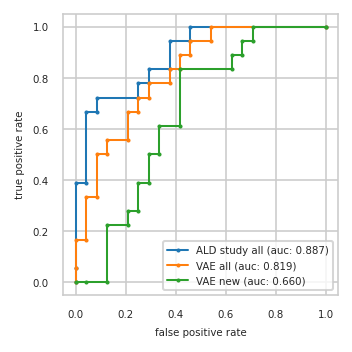

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.167   0.125 0.000
3          0.042 0.389   0.042 0.167   0.125 0.222
4          0.042 0.667   0.042 0.333   0.208 0.222
5          0.083 0.667   0.083 0.333   0.208 0.278
6          0.083 0.722   0.083 0.500   0.250 0.278
7          0.250 0.722   0.125 0.500   0.250 0.389
8          0.250 0.778   0.125 0.556   0.292 0.389
9          0.292 0.778   0.208 0.556   0.292 0.500
10         0.292 0.833   0.208 0.667   0.333 0.500
11         0.375 0.833   0.250 0.667   0.333 0.611
12         0.375 0.944   0.250 0.722   0.417 0.611
13         0.458 0.944   0.292 0.722   0.417 0.833
14         0.458 1.000   0.292 0.778   0.625 0.833
15         1.000 1.000   0.375 0.778   0.625 0.889
16           NaN   NaN   0.375 0.833   0.667 0.889
17           NaN   NaN   0.417 0.833   0.667 0.944
18           NaN   NaN   0.417 0.889   0.708 0.944
19           NaN   NaN   0.458 0.889   0.708 1.000
20           NaN   NaN   0.458 0.944   1.000 1.000
21           NaN   NaN   0.542 0.944     NaN   NaN
22           NaN   NaN   0.542 1.000     NaN   NaN
23           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,K7ER15;Q9H0R4;Q9H0R4-2,Q9UMX0;Q9UMX0-2;Q9UMX0-4
2,P09486,P02741,P16519;P16519-3
3,K7ERG9;P00746,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,P14174,Q9Y2T3;Q9Y2T3-3,P31321
5,P10636-2;P10636-6,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,P61981,P14174,Q9NUQ9
7,Q6EMK4,Q14894,Q96GD0
8,Q9Y2T3;Q9Y2T3-3,P25189;P25189-2,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


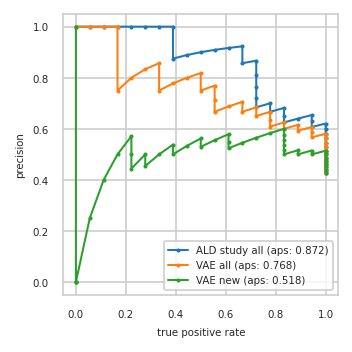

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.593 0.889     0.556 0.833
16         0.654 0.944     0.615 0.889     0.577 0.833
17         0.640 0.889     0.600 0.833     0.600 0.833
18         0.625 0.833     0.625 0.833     0.583 0.778
19         0.652 0.833     0.609 0.778     0.565 0.722
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.667 0.778     0.524 0.611
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.765 0.722     0.706 0.667     0.529 0.500
26         0.812 0.722     0.688 0.611     0.562 0.500
27         0.867 0.722     0.667 0.556     0.533 0.444
28         0.857 0.667     0.714 0.556     0.500 0.389
29         0.923 0.667     0.769 0.556     0.538 0.389
30         0.917 0.611     0.750 0.500     0.500 0.333
31         0.909 0.556     0.818 0.500     0.455 0.278
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.444 0.222
34         0.875 0.389     0.750 0.333     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.250 0.056
39         1.000 0.167     1.000 0.167     0.000 0.000
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


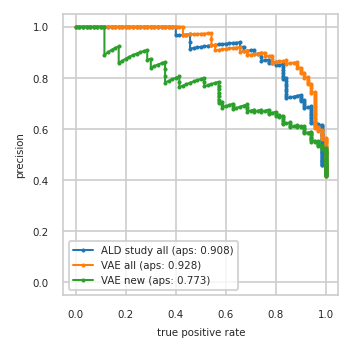

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


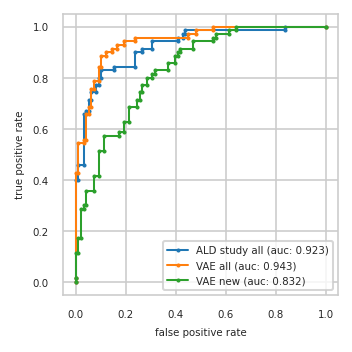

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}